# Spiral - 2.0
The trying to make a some like this

http://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=8,8,8,8&seed=0.69219&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

but on tensorflow

In [144]:
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

epoch_for_train=1000 #How long to train
samples_per_epoch=250 #The playground.tensorflow.org has 250 train points (and 250 for test)
train_batch_size = 10 #10 as at the playground
summary_every_epoch = 100 #print loss
layers_sizes = [8,8,8,8, 1] #network configuration: every value is layer size

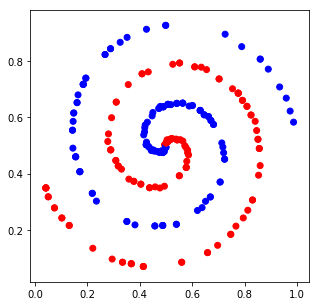

In [145]:
#generating data function - some derivative from playground code
def generate_data(num_of_data):
    xs = np.zeros((num_of_data, 2))
    ys = np.zeros((num_of_data, 1))
    noise=0.01
    size=1

    for i in range(int(num_of_data)):
        if (i%2):    #positive examples
            r = i / num_of_data/2 * size;
            t = 1.75 * i / num_of_data  * math.pi*2;
            xs[i][0] = size/2+r * math.sin(t) + (random.random()-0.5) * noise;
            xs[i][1] = size/2+r * math.cos(t) + (random.random()-0.5) * noise;
            ys[i][0] = 1
        else: #negative examples
            r = i / num_of_data/2 * size;
            t = 1.75 * i / num_of_data  * math.pi*2 +math.pi;
            xs[i][0] = size/2+r * math.sin(t) + (random.random()-0.5) * noise;
            xs[i][1] = size/2+r * math.cos(t) + (random.random()-0.5) * noise;
            ys[i][0] = 0
    return xs, ys

#let's generate: data_x(samples_per_epoch,2) with coordinates of point and data_y(samples_per_epoch,1) with value
data_x, data_y=generate_data(samples_per_epoch)

#function to feed tensorflow dictionary. Returns a random points from generated data as arrays with batch_size len
dict_index=0
def feed_my_dict(x,y_,batch_size):
    global dict_index
    xs = np.zeros((batch_size, 2))
    ys = np.zeros((batch_size, 1))
    for i in range(batch_size):
        dict_index=int(round(random.random()*(len(data_x[:,0])-1)))
        xs[i][0] = data_x[dict_index,0]
        xs[i][1] = data_x[dict_index,1]
        ys[i][0] = data_y[dict_index,0]
    return {x: xs, y_: ys}


#let's draw generated data
fig, ax = plt.subplots(figsize=(5,5))

#For whole epoch 
for j in range(int(samples_per_epoch/train_batch_size)):
    my_x="x"
    my_y="y"
    #call function that is used for feed tensorflow (to verify it)
    feed_dict=feed_my_dict(my_x,my_y,train_batch_size)
    colors = []
    #to colorize data find max and min y in data
    y_max=np.max(feed_dict[my_y][:,0])
    y_min=np.min(feed_dict[my_y][:,0])    
    for i in range(len(feed_dict[my_y][:,0])):#for all batch
        output=(feed_dict[my_y][i,0]-y_min)/(y_max-y_min) #create normalised to 0-1 value
        colors.append((int(output),0,int(1-output)))#color: R-part max when data is '1', B-part max when 0. G always 0
    ax.scatter(feed_dict[my_x][:,0], feed_dict[my_x][:,1], color=colors) #plot all batch points
plt.show()

Creating network with sizes:
[8, 8, 8, 8, 1]
Loss at epoch 0: 0.3042
Loss at epoch 100: 0.207872
Loss at epoch 200: 0.189411
Loss at epoch 300: 0.125937
Loss at epoch 400: 0.0458682
Loss at epoch 500: 0.0199103
Loss at epoch 600: 0.0189641
Loss at epoch 700: 0.0161539
Loss at epoch 800: 0.00664738
Loss at epoch 900: 0.0089955


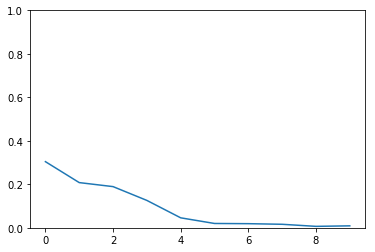

In [146]:
print("Creating network with sizes:")
print(layers_sizes)

sess = tf.Session()
# Create a multilayer tensorflow model.

# Input placeholders
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 2], name='x-input')
    y_ = tf.placeholder(tf.float32, [None, 1], name='y-input')

# We can't initialize these variables to 0 - the network will get stuck.
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.5)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.

    It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])

        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])

        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases

        activations = act(preactivate, name='activation')
        return activations

#with function nn_layer we create network configuration as defined in layers_sizes array
#and save output tensors for all layers in layers=[] array
layers=[]
for n in range(len(layers_sizes)):
    if n == 0:#first layer - special, as input - raw data x (placeholder)
        activations=nn_layer(x, 2, layers_sizes[0], "layer" + str(n))
    else:
        if (n==(len(layers_sizes)-1)):#output layer - special, as activation tanh (as at playground)
            activations = nn_layer(layers[n-1], layers_sizes[n - 1], layers_sizes[n], "layer" + str(n)) #, tf.nn.tanh
        else: #other layers - there are same way to creating
            activations = nn_layer(layers[n-1], layers_sizes[n - 1], layers_sizes[n], "layer" + str(n))
    layers.append(activations)

y = layers[len(layers_sizes) - 1] #define as 'y' our last output layer

#mean square loss - as at playground
loss=tf.reduce_mean(tf.square(y_-y))

#at the playground vanilla gradient descent is used, but it barely works here
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(loss)


sess.run(tf.global_variables_initializer())

loss_pic=[]
#traning
for i in range(epoch_for_train):
    if ((i % summary_every_epoch) == 0):#print loss
        loss_my = sess.run(loss, feed_dict=feed_my_dict(x,y_,samples_per_epoch))
        loss_pic.append(loss_my)
        print('Loss at epoch %s: %s' % (i, loss_my))
    for j in range(int(samples_per_epoch/train_batch_size)):#one train_step run one batch data
        sess.run(train_step, feed_dict=feed_my_dict(x,y_,train_batch_size))

#let's draw loss
fig, ax = plt.subplots()
ax.plot(loss_pic) #plot all batch points
ax.set_ylim([0,1])
plt.show()

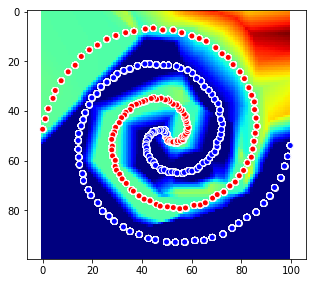

In [147]:
#let's try to draw output picture as at the playground. To do this create a grid as input data
#and give it to our model for calculating 'y' (output). Given 'y' we can draw picture of activation


#special feed dictionry for this - simple grid with some dimension
def feed_dict_for_plot(x,y_,dimension):   
    xs = np.zeros((dimension*dimension, 2))
    ys = np.zeros((dimension*dimension, 1))
    index = 0
    for i in range(dimension):
        for j in range(dimension):
            xs[index][0] = i / dimension
            xs[index][1] = j / dimension
            ys[index][0] = 0 #we do not train the model, so we don't define labels
            index += 1
    return {x: xs, y_: ys}

#resolution for our picture
image_size=100
#feed model our grid
#returned array shape is (image_size^2, 1)
my_outputs = sess.run(layers, feed_dict=feed_dict_for_plot(x,y_,image_size))
output_activation = my_outputs[len(layers_sizes) - 1][:,0] #get rid of last '1' dimension


#Making rgb picture from output data
def out_data_to_rgb(my_y,dimension):
    y_max=np.max(my_y)
    if (y_max==0):
        y_max=0.1
    #normalize output and create color by jet colormap. Color returned with alpha channel, get rid of it by slises
    my_data=cm.jet(my_y/y_max)[:,0:3]
    #flat array to dimension*dimension
    out_picture=np.reshape(my_data,(dimension,dimension,3))
    out_picture=np.transpose(out_picture,(1,0,2))
    return out_picture

#let's draw output
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(out_data_to_rgb(output_activation,image_size))


#finaly add our dataset at the top of picture as reference
colors = []
y_max=np.max(data_y[:,0])
y_min=np.min(data_y[:,0])   
for i in range(len(data_y[:,0])):
    output=(data_y[i,0]-y_min)/(y_max-y_min)
    colors.append((int(output),0,int(1-output)))
    ax.scatter(data_x[:,0]*image_size, data_x[:,1]*image_size, color=colors, edgecolors ='w')
plt.show()

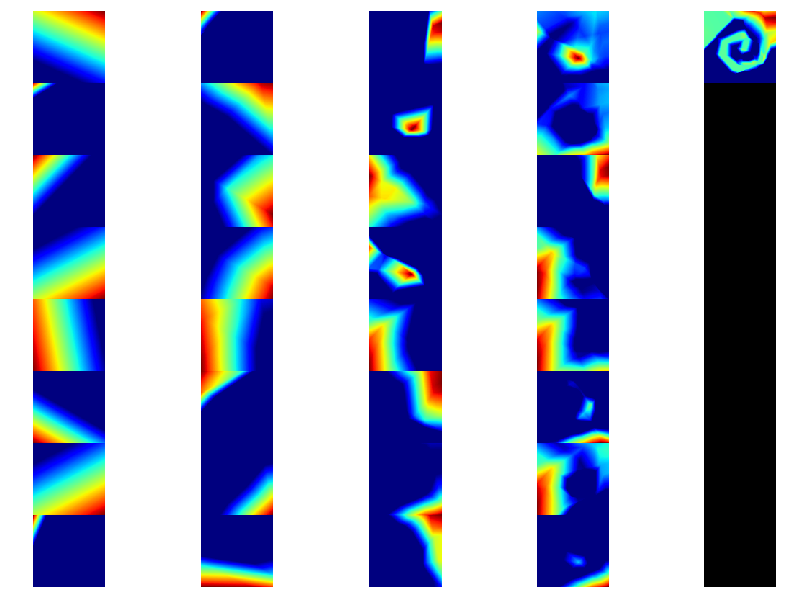

In [148]:
#we have my_outputs - outputs of all neurons
#We can draw it too same way as we draw output before
image_data = []
image_num=0
#create grid of pictures
fig = plt.figure(figsize=(len(layers_sizes)*3, max(layers_sizes)))
gs1 = gridspec.GridSpec(max(layers_sizes), len(layers_sizes))
gs1.update(wspace=0.01, hspace=0.0) # set the spacing between axes.
fig.subplots_adjust(bottom=0.0,  top=1, wspace=0, hspace=0)

for n in range(len(layers_sizes)):# by layers
    for m in range(max(layers_sizes)): #by neurons
        image_num=len(layers_sizes)*m+n
        ax = plt.subplot(gs1[image_num])
        if (m<layers_sizes[n]):
            output_activation=my_outputs[n][:,m]
            ax.imshow(out_data_to_rgb(output_activation,image_size))
        else:#black picture for layer with less neurons
            ax.imshow(np.zeros([image_size, image_size, 3]))
        ax.axis('off')  # clear x- and y-axes
plt.show()
